Found 525 instances in data/train_data
Found 0 categories in data/modelnet40

--- Raw output from InstanceLevelDataset[0] (paths, not tensors) ---
Name: 0461
Num model paths: 1
Num image paths: 26
Example model path: data/train_data/models/0461.stl
Example image path: data/train_data/images/0461_6.png

--- Getting a processed batch from DataLoader ---
Batch keys: dict_keys(['name', 'model_points', 'image'])
Batch names: ['0471', '0514']
Batch image tensor shape: torch.Size([2, 1, 224, 224])
Batch model_points tensor shape: torch.Size([2, 2048, 3])

--- Visualizing a sample processed by the collate_fn ---


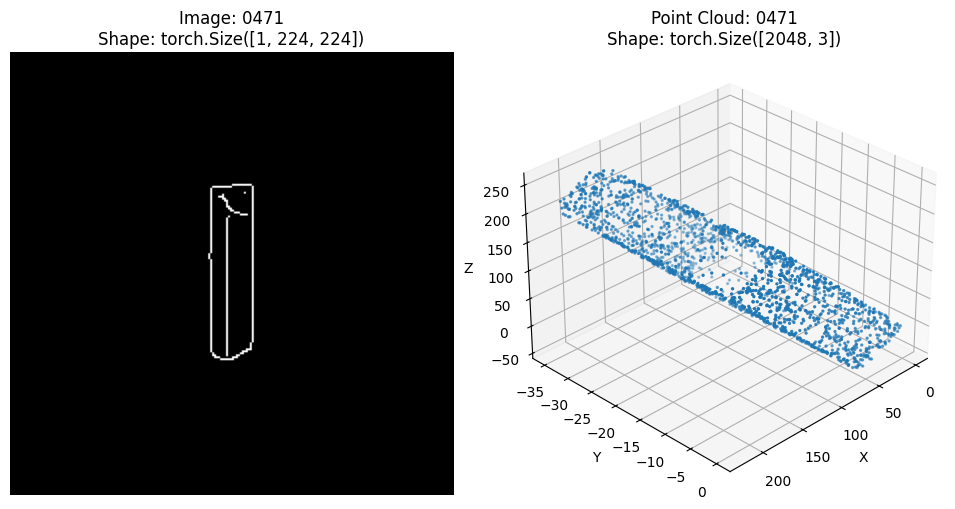

In [ ]:
import os
import torch
import numpy as np
import trimesh
from PIL import Image
from skimage.feature import canny
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
import functools # For the collate_fn

# --- (The helper functions and augmentation classes from before remain the same) ---

def sample_points_from_stl(stl_path, num_points=2048):
    """Loads an STL file and samples points from its surface."""
    try:
        mesh = trimesh.load(stl_path, force='mesh')
        points = mesh.sample(num_points)
        return torch.from_numpy(points).float()
    except Exception as e:
        print(f"Warning: Could not load or sample {stl_path}. Error: {e}.")
        return None

class PointCloudAugmentation:
    """Applies augmentations to a point cloud."""
    def __init__(self, rotation_axis='y', jitter_std=0.01, points_add_remove_ratio=0.1):
        self.rotation_axis = rotation_axis
        self.jitter_std = jitter_std
        self.points_add_remove_ratio = points_add_remove_ratio

    def __call__(self, points):
        theta = np.random.uniform(0, 2 * np.pi)
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        rotation_matrix = torch.tensor([[cos_t, 0, sin_t], [0, 1, 0], [-sin_t, 0, cos_t]], dtype=points.dtype)
        points = points @ rotation_matrix
        points += torch.randn_like(points) * self.jitter_std
        num_points = points.shape[0]
        num_to_modify = int(num_points * self.points_add_remove_ratio)
        indices_to_keep = np.random.choice(num_points, num_points - num_to_modify, replace=False)
        points = points[indices_to_keep]
        indices_to_duplicate = np.random.choice(points.shape[0], num_to_modify, replace=True)
        points = torch.cat([points, points[indices_to_duplicate]], dim=0)
        return points

def edge_detection_transform(image_tensor):
    image_np = image_tensor.squeeze(0).cpu().numpy()
    edges = canny(image_np, sigma=1)
    return torch.from_numpy(edges).float().unsqueeze(0)

image_augmentations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    # transforms.RandomAutocontrast(p=0.5),
    # transforms.Lambda(edge_detection_transform),
])

# --- 3. The Revised Dataset Classes ---

class BaseCADDataset(Dataset):
    """Base class for CAD datasets, now returning lists of paths."""
    def __init__(self, root_dir):
        self.root_dir = root_dir
        # _load_data_groups will return a list of dictionaries.
        # Each dict represents one "item" (a category or an instance).
        self.data_groups = self._load_data_groups()

    def _load_data_groups(self):
        # Must be implemented by subclasses
        raise NotImplementedError

    def __len__(self):
        return len(self.data_groups)

    def __getitem__(self, idx):
        # Returns paths, not loaded data, for memory efficiency
        return self.data_groups[idx]

    def render_model(self, model_path):
        """Placeholder for rendering a single model to an image."""
        print(f"Rendering {model_path}... (Not implemented)")
        # User will implement this. It should return a PIL Image.
        return Image.new('RGB', (224, 224), 'gray')

    def render_dataset(self):
        """Placeholder for rendering all models in the dataset that lack images."""
        print("Checking for models without images and rendering... (Not implemented)")
        # User will implement logic to iterate, check, and call render_model
        pass

class InstanceLevelDataset(BaseCADDataset):
    """Dataset for instance-level structure (e.g., Thingi10k)."""
    def _load_data_groups(self):
        model_dir = Path(self.root_dir) / 'models'
        image_dir = Path(self.root_dir) / 'images'
        
        # Group images by their corresponding model name
        image_map = defaultdict(list)
        for image_path in image_dir.glob('*'):
            if image_path.suffix in ['.jpg', '.png']:
                model_name = image_path.stem.split('_')[0]
                image_map[model_name].append(image_path)
                
        data_groups = []
        for model_path in model_dir.glob('*.stl'):
            model_name = model_path.stem
            if model_name in image_map:
                data_groups.append({
                    "name": model_name,
                    "model_paths": [model_path], # List with a single model
                    "image_paths": image_map[model_name] # List of all its images
                })

        print(f"Found {len(data_groups)} instances in {self.root_dir}")
        return data_groups

class CategoryLevelDataset(BaseCADDataset):
    """Dataset for category-level structure (e.g., ModelNet40)."""
    def _load_data_groups(self):
        data_groups = []
        categories = [d for d in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, d))]
        
        for category in categories:
            category_path = Path(self.root_dir) / category
            model_paths = list(category_path.glob('models/*.stl'))
            image_paths = list(category_path.glob('images/*.png')) + list(category_path.glob('images/*.jpg'))
            
            if model_paths and image_paths:
                data_groups.append({
                    "name": category,
                    "model_paths": model_paths, # List of all models in category
                    "image_paths": image_paths, # List of all images in category
                })

        print(f"Found {len(data_groups)} categories in {self.root_dir}")
        return data_groups

# --- 4. The Custom Collate Function ---

def collate_fn_for_retrieval(batch, image_transform, model_transform, num_points=2048):
    """
    Custom collate_fn to process a batch of path groups.
    For each item in the batch, it samples one model and one image,
    loads them, applies augmentations, and creates a final tensor batch.
    """
    batch_images = []
    batch_points = []
    batch_names = []

    for data_group in batch:
        # For each group, randomly sample one model and one image path
        model_path = np.random.choice(data_group['model_paths'])
        image_path = np.random.choice(data_group['image_paths'])
        
        # --- Load and Augment Model ---
        points = sample_points_from_stl(model_path, num_points)
        if points is None: continue # Skip if model loading failed
        if model_transform:
            points = model_transform(points)
        
        # --- Load and Augment Image ---
        image = Image.open(image_path).convert('RGB')
        if image_transform:
            image = image_transform(image)
            
        batch_images.append(image)
        batch_points.append(points)
        batch_names.append(data_group['name'])

    # Stack the lists of tensors into a single batch tensor
    return {
        "name": batch_names,
        "model_points": torch.stack(batch_points),
        "image": torch.stack(batch_images)
    }

# --- 5. Usage Example ---

def create_dummy_data(base_dir="data"):
    # (This function is the same as before)
    if os.path.exists(base_dir): return
    thingi_path = Path(base_dir) / "thingi10k"; (thingi_path / "models").mkdir(parents=True, exist_ok=True); (thingi_path / "images").mkdir(parents=True, exist_ok=True)
    trimesh.creation.box().export(thingi_path / "models/box.stl"); trimesh.creation.sphere().export(thingi_path / "models/sphere.stl")
    Image.new('RGB', (100, 100)).save(thingi_path / "images/box_render_1.jpg"); Image.new('RGB', (100, 100)).save(thingi_path / "images/box_render_2.jpg"); Image.new('RGB', (100, 100)).save(thingi_path / "images/sphere_render_1.jpg")
    modelnet_path = Path(base_dir) / "modelnet40"; (modelnet_path / "chair/models").mkdir(parents=True, exist_ok=True); (modelnet_path / "chair/images").mkdir(parents=True, exist_ok=True)
    trimesh.creation.box((0.8, 1, 0.8)).export(modelnet_path / "chair/models/chair_1.stl"); Image.new('RGB', (100, 100)).save(modelnet_path / "chair/images/chair_view_1.png")
    print("Dummy data created.")

def visualize_sample(sample):
    """Visualizes a single sample from the dataset."""
    fig = plt.figure(figsize=(10, 5))

    # Plot image
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(sample['image'].squeeze(), cmap='gray')
    ax1.set_title(f"Image: {sample['name']}\nShape: {sample['image'].shape}")
    ax1.axis('off')

    # Plot point cloud (2D projection)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    points = sample['model_points'].numpy()
    ax2.scatter(points[:, 0], points[:, 1], points[:, 2], s=2)
    ax2.set_title(f"Point Cloud: {sample['name']}\nShape: {sample['model_points'].shape}")
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.view_init(elev=30, azim=45)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    create_dummy_data()

    # --- Instantiate Datasets ---
    instance_dataset = InstanceLevelDataset(root_dir="data/train_data")
    category_dataset = CategoryLevelDataset(root_dir="data/modelnet40")

    # --- Let's inspect the raw output of the dataset ---
    print("\n--- Raw output from InstanceLevelDataset[0] (paths, not tensors) ---")
    first_instance = instance_dataset[0]
    print(f"Name: {first_instance['name']}")
    print(f"Num model paths: {len(first_instance['model_paths'])}")
    print(f"Num image paths: {len(first_instance['image_paths'])}")
    print(f"Example model path: {first_instance['model_paths'][0]}")
    print(f"Example image path: {first_instance['image_paths'][0]}")

    # --- Setup Augmentations ---
    point_cloud_augmentations = PointCloudAugmentation()
    
    # --- Create DataLoader with the custom collate_fn ---
    # We use functools.partial to pass the transforms to the collate function
    collate_with_transforms = functools.partial(
        collate_fn_for_retrieval,
        image_transform=image_augmentations,
        model_transform=point_cloud_augmentations
    )
    
    if len(instance_dataset) > 0:
        data_loader = DataLoader(
            instance_dataset, 
            batch_size=2, 
            shuffle=True, 
            collate_fn=collate_with_transforms
        )

        # --- Get one batch from the DataLoader ---
        print("\n--- Getting a processed batch from DataLoader ---")
        batch = next(iter(data_loader))
        print("Batch keys:", batch.keys())
        print("Batch names:", batch['name'])
        print("Batch image tensor shape:", batch['image'].shape)
        print("Batch model_points tensor shape:", batch['model_points'].shape)
        
        # --- Visualize a sample from the PROCESSED BATCH ---
        sample_from_batch = {
            "name": batch['name'][0],
            "image": batch['image'][0],
            "model_points": batch['model_points'][0]
        }
        print("\n--- Visualizing a sample processed by the collate_fn ---")
        # Re-using the visualization function from the previous code
        visualize_sample(sample_from_batch)